In [95]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import math
import pickle
import sys
import scipy.io as sio

In [96]:
def LoadBatch(filename):
    with open('Dataset/'+filename, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict


In [97]:
def one_hot(labels):
    unique_val=np.unique(labels)
    #display(labels)
    encoded=np.zeros((np.shape(labels)[0],np.shape(unique_val)[0]))
    for idx, val in enumerate(labels):
        encoded[idx][val] = 1
    return encoded
        
   

In [98]:
def loading_batch(filename):
    dict_data=LoadBatch(filename)
    data=(dict_data[b'data'].T)# of shape d*n where rows are the dimensionsionality cols are the images
    labels=(dict_data[b'labels'])# list of labels for each image in training
    encoded_labels=one_hot(labels).T#one hot encode list of labels of training data 10*n
    return data,labels,encoded_labels
    

In [81]:
X,y,Y=loading_batch('data_batch_1')
batches = LoadBatch('cifar-10-batches-py/batches.meta')
labels = [label_name.decode('utf-8') for label_name in batches[b'label_names']]

In [82]:
Xval,yval,Yval=loading_batch('data_batch_2')
Xtest,ytest,Ytest = loading_batch('test_batch')

In [83]:
def normalize(trainX,Xval,Xtest=None):
        trainX=np.float64(trainX)
        Xval=np.float64(Xval)
        
        mean_X =trainX.mean(axis=1)

        std_X=trainX.std(axis=1)

        X=trainX-mean_X[:,None]

        X=X/std_X[:,None]
        Xval=Xval-mean_X[:,None]
        Xval=Xval/std_X[:,None]
        
        if(Xtest is not None):
            Xtest=np.float64(Xtest)
            Xtest=Xtest-mean_X[:,None]
            Xtest=Xtest/std_X[:,None]
            return X,Xval,Xtest;
        
        
        
        return X,Xval;
        
      

In [70]:
X,Xval=normalize(X,Xval)

In [71]:
X.shape

(3072, 10000)

In [72]:
Y.shape

(10, 10000)

In [103]:
def intitalize_weighs(X):
    d=X.shape[0]#input dimension
    k=10# no of class labels outpurt dimension
    m=50#hidden dimension
    W1 = np.random.normal(size=(m, d), loc=0, scale=(1/np.sqrt(d)))
    W2= np.random.normal(size=(k, m), loc=0, scale=(1/np.sqrt(m)))
    b1=np.zeros(shape=(m,1))
    b2=np.zeros(shape=(k,1))
    return W1,W2,b1,b2
    

In [104]:
W1,W2,b1,b2=intitalize_weighs(X)

In [13]:
W1.shape

(50, 3072)

In [14]:
W2.shape

(10, 50)

In [15]:
b1.shape

(50, 1)

In [16]:
b2.shape

(10, 1)

In [7]:
def relu(x):
    return x * (x > 0)
    

In [8]:
def softmax(S):
    exponential_S = np.exp(S)
    P = exponential_S/exponential_S.sum(axis=0)
    return P

In [9]:
def EvaluateClassifier(W1,W2,b1,b2,X):
    S1=W1@X+b1
    h1=relu(S1)
    S2=W2@h1+b2
    P=softmax(S2)
    return P,h1
    

In [10]:
def ComputeCost(X, Y, W1, b1, W2, b2, lambdaX):
    P, H = EvaluateClassifier( W1,  W2,b1, b2,X)
    lcr=-np.sum(np.multiply(Y,np.log(P)))
    Reg_term=lambdaX*((W1**2).sum()+(W2**2).sum())
    J=lcr/X.shape[1]+Reg_term
    return J
    
    
    

In [11]:
def ComputeGradients(X,Y,P,H,W1,W2,b1,b2,lambdaX):
    n=X.shape[1]
    C = Y.shape[0]
    G=-(Y-P)
    d= H.shape[0]
    grad_W2=np.dot(G,H.T)/n+2*lambdaX*W2
    
    grad_b2=(np.dot(G,np.ones(shape=(n,1)))/n).reshape(C,1)
    G= W2.T@G
    G = G*(H>0)
    
    
    grad_W1=np.dot(G,X.T)/n+2*lambdaX*W1
    
    grad_b1=(np.dot(G,np.ones(shape=(n,1)))/n).reshape(d,1)
    
    return grad_W1,grad_b1,grad_W2,grad_b2
    
    
    

In [12]:
def ComputeGradsNum(X, Y, W1, b1, W2, b2, lambdaX, h=0.00001):
    grad_W2 = np.zeros(shape=W2.shape)
    grad_b2 = np.zeros(shape=b2.shape)
    grad_W1 = np.zeros(shape=W1.shape)
    grad_b1 = np.zeros(shape=b1.shape)   
    c = ComputeCost(X, Y, W1, b1, W2, b2, lambdaX)
    
    for i in range(b1.shape[0]):
        b1_try = b1.copy()
        b1_try[i,0] = b1_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1_try, W2, b2, lambdaX)
        grad_b1[i,0] = (c2-c)/h
    
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1_try = W1.copy()
            W1_try[i,j] = W1_try[i,j]+h
            c2 = ComputeCost(X, Y, W1_try, b1, W2, b2, lambdaX)
            grad_W1[i,j] = (c2-c)/h
    
    for i in range(b2.shape[0]):
        b2_try = b2.copy()
        b2_try[i,0] = b2_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, b1, W2, b2_try, lambdaX)
        grad_b2[i,0] = (c2-c)/h
    
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2_try = W2.copy()
            W2_try[i,j] = W2_try[i,j]+h
            c2 = ComputeCost(X, Y, W1, b1, W2_try, b2, lambdaX)
            grad_W2[i,j] = (c2-c)/h
    
    return grad_W1,grad_b1,grad_W2,grad_b2

In [13]:
def error_check(W1,W2,b1,b2,X,Y,lambdax=0):
    P, H = EvaluateClassifier( W1,  W2,b1, b2,X)
    grad_W1_a,grad_b1_a,grad_W2_a,grad_b2_a=ComputeGradients(X,Y,P,H,W1,W2,b1,b2,lambdax)
    grad_W1_n,grad_b1_n,grad_W2_n,grad_b2_n=ComputeGradsNum(X, Y, W1, b1, W2, b2, lambdax, h=0.000001)
    grad_W1_abs_err = np.abs(grad_W1_n-grad_W1_a)
    grad_b1_abs_err = np.abs(grad_b1_n-grad_b1_a)
    grad_W2_abs_err = np.abs(grad_W2_n-grad_W2_a)
    grad_b2_abs_err = np.abs(grad_b2_n-grad_b2_a)
    print('w1: '+str(np.mean(grad_W1_abs_err<1e-6)*100)+"% of absolute errors below 1e-6")
    print('b1: '+str(np.mean(grad_b1_abs_err<1e-6)*100)+"% of absolute errors below 1e-6")
    print('w2: '+str(np.mean(grad_W2_abs_err<1e-6)*100)+"% of absolute errors below 1e-6")
    print('b2: '+str(np.mean(grad_b2_abs_err<1e-6)*100)+"% of absolute errors below 1e-6")
    grad_W1_rel_err = np.maximum(np.abs(grad_W1_n)+np.abs(grad_W1_a), 0.00000001)
    grad_b1_rel_err = np.maximum(np.abs(grad_b1_n)+np.abs(grad_b1_a), 0.00000001)
    grad_W2_rel_err = np.maximum(np.abs(grad_W2_n)+np.abs(grad_W2_a), 0.00000001)
    grad_b2_rel_err = np.maximum(np.abs(grad_b2_n)+np.abs(grad_b2_a), 0.00000001)
    print('w1: '+str(np.mean(grad_W1_abs_err/grad_W1_rel_err<1e-6)*100)+
      "% of relative errors below 1e-6")
    print('b1: '+str(np.mean(grad_b1_abs_err/grad_b1_rel_err<1e-6)*100)+
          "% of relative errors below 1e-6")
    print('w2: '+str(np.mean(grad_W2_abs_err/grad_W2_rel_err<1e-6)*100)+
          "% of relative errors below 1e-6")
    print('b2: '+str(np.mean(grad_b2_abs_err/grad_b2_rel_err<1e-6)*100)+
          "% of relative errors below 1e-6")

In [24]:
error_check(W1[:,0:20],  W2,b1, b2,X[0:20,[0]],Y[:,[0]])

w1: 100.0% of absolute errors below 1e-6
b1: 100.0% of absolute errors below 1e-6
w2: 100.0% of absolute errors below 1e-6
b2: 100.0% of absolute errors below 1e-6
w1: 98.4% of relative errors below 1e-6
b1: 98.0% of relative errors below 1e-6
w2: 100.0% of relative errors below 1e-6
b2: 100.0% of relative errors below 1e-6


In [25]:
error_check(W1, W2,b1, b2,X[:,0:5],Y[:,0:5],0.01)

w1: 100.0% of absolute errors below 1e-6
b1: 100.0% of absolute errors below 1e-6
w2: 100.0% of absolute errors below 1e-6
b2: 100.0% of absolute errors below 1e-6
w1: 74.84635416666666% of relative errors below 1e-6
b1: 98.0% of relative errors below 1e-6
w2: 84.0% of relative errors below 1e-6
b2: 100.0% of relative errors below 1e-6


In [14]:
def ComputeAccuracy(X, y, W1, b1, W2, b2):
    P, H = EvaluateClassifier(W1,W2,b1,b2,X)
    acc = np.mean(y==np.argmax(P, 0))
    return acc

In [15]:
def MiniBatchGD(X, Y, y, GDparams, W1, W2, b1, b2, X_val=None, Y_val=None, y_val=None, lambdax= 0 ):
    n = X.shape[1]
    (eta_min,eta_max,step_size,n_batch,cycles)=GDparams
    metrics = {'updates':[-1], 
               'Loss_scores':[ComputeCost(X, Y, W1, b1, W2, b2, lambdax)], 
               'acc_scores':[ComputeAccuracy(X, y, W1, b1, W2, b2)]}
    if X_val is not None:
        metrics['Loss_val_scores'] = [ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambdax)]
        metrics['acc_val_scores'] = [ComputeAccuracy(X_val, y_val, W1, b1, W2, b2)]
    batches = dict()
    max_batch_index = n//n_batch-1
    for j in range(n//n_batch):
            j_start = (j)*n_batch ;
            j_end = (j+1)*n_batch;
            inds = range(j_start,j_end);
            y_batch = [y[index] for index in inds]
            X_batch = X[:, inds];
            Y_batch = Y[:, inds];
            batches[j]=(X_batch,Y_batch,y_batch)

    j = 0
    
    for l in range(cycles):
        for t in range(2*l*step_size, 2*(l+1)*step_size):
            
            
            if t>= 2*l*step_size and t<(2*l+1)*step_size:
                eta = eta_min+(t-2*l*step_size)/step_size*(eta_max-eta_min)
            elif t>=(2*l+1)*step_size and t<2*(l+1)*step_size:
                eta = eta_max-(t-(2*l+1)*step_size)/step_size*(eta_max-eta_min)

            X_batch, Y_batch, y_batch = batches[j]
            P_batch, H_batch = EvaluateClassifier( W1,  W2,b1, b2,X_batch)
            grad_W1, grad_b1,grad_W2, grad_b2 = ComputeGradients(X_batch,Y_batch,P_batch,H_batch,W1,W2,b1,b2,lambdax)
            W1 += -eta*grad_W1
            b1 += -eta*grad_b1
            W2 += -eta*grad_W2
            b2 += -eta*grad_b2
            j += 1
            if j>(n//n_batch-1):
                j = 0
                metrics['updates'].append(t+1)
                metrics['acc_scores'].append(ComputeAccuracy(X, y, W1, b1, W2, b2))
                metrics['Loss_scores'].append(ComputeCost(X, Y, W1, b1, W2, b2, lambdax))
                if X_val is not None:
                    metrics['acc_val_scores'].append(ComputeAccuracy(X_val, y_val, W1, b1, W2, b2))
                    metrics['Loss_val_scores'].append(ComputeCost(X_val, Y_val, W1, b1, W2, b2, lambdax))
                message = "In update "+str(t+1)+'/'+str(2*cycles*step_size)+" finishes epoch "+ \
                          str(len(metrics['updates'])-1)+": loss="+str(metrics['Loss_scores'][-1])+ \
                          " and accuracy="+str(metrics['acc_scores'][-1])+" (training set) \r"
                sys.stdout.write(message)
            
        
    
    return W1, b1, W2, b2, metrics


In [28]:
eta_min=1e-5
eta_max=1e-1
step_size=500
n_batch=10
cycles=2 
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)
W1_check, b1_check, W2_check, b2_check, metrics_check= \
    MiniBatchGD(X[:,0:100], Y[:,0:100], y[0:100], GDparams, W1, W2, b1, b2, lambdax=0)

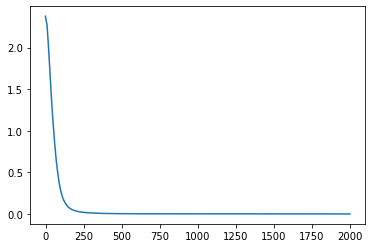

In [30]:
plt.plot(metrics_check['updates'],metrics_check['Loss_scores'])

In [31]:
eta_min=1e-5
eta_max=1e-1
step_size=500
n_batch=100
cycles=1 
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)
W1_3, b1_3, W2_3, b2_3, metrics_3= MiniBatchGD(X, Y, y, GDparams, W1, W2, b1, b2,Xval,Yval,yval, lambdax=0.01)

In [16]:
def plot_graph(metrics):
    plt.plot(metrics['updates'],metrics['Loss_scores'], color='green', marker='o',mfc='pink',label='training' )
    plt.plot(metrics['updates'],metrics['Loss_val_scores'], color='magenta', marker='o',mfc='green' )
    plt.ylabel('loss') #set the label for y axis
    plt.xlabel('update step') #set the label for x-axis
    plt.legend(loc="upper right")
    plt.show()
    
    
    plt.plot(metrics['updates'],metrics['acc_scores'], color='green', marker='o',mfc='green',label='training' )
    plt.plot(metrics['updates'],metrics['acc_val_scores'], color='magenta', marker='o',mfc='magenta',label='validation' )
    plt.ylabel('accuracy') #set the label for y axis
    plt.xlabel('update step') #set the label for x-axis
    plt.legend(loc="upper right")
    plt.show()

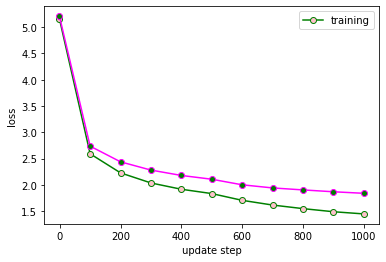

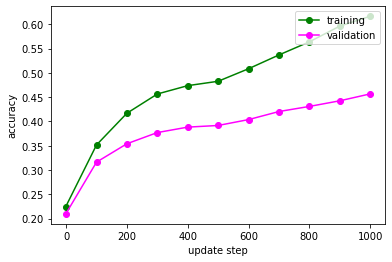

In [33]:
plot_graph(metrics_3)

In [48]:
eta_min=1e-5
eta_max=1e-1
step_size=800
n_batch=100
cycles=3 
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)
W1_4, b1_4, W2_4, b2_4, metrics_4= MiniBatchGD(X, Y, y, GDparams, W1, W2, b1, b2,Xval,Yval,yval, lambdax=0.01)

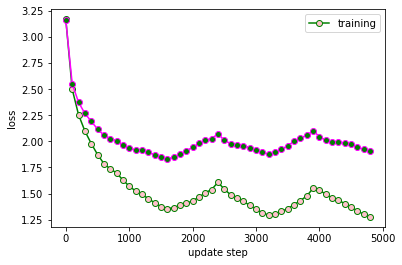

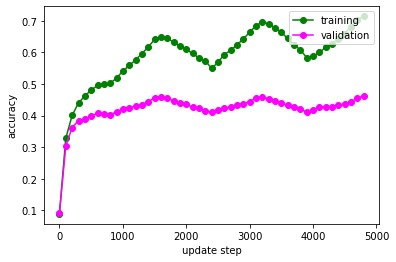

In [49]:
plot_graph(metrics_4)

In [27]:
def gridsearchCV(lambdas, hidden_dimension, X, Y, y, GDparams, X_val=None,
                Y_val=None, y_val=None):
    metrics_grid = {'Loss_scores':[], 'acc_scores':[]}
    if X_val is not None:
        metrics_grid['Loss_val_scores'] = []
        metrics_grid['acc_val_scores'] = []
    
    for lambdax in lambdas:
        
        W1,W2,b1,b2=intitalize_weighs(X)
        W1_4, b1_4, W2_4, b2_4, metrics=MiniBatchGD(X, Y, y, GDparams, W1, W2, b1, b2,X_val,Y_val,y_val, lambdax)
        metrics_grid['Loss_scores'].append(metrics['Loss_scores'][-1])
        metrics_grid['acc_scores'].append(metrics['acc_scores'][-1])
        if X_val is not None:
            metrics_grid['Loss_val_scores'].append(metrics['Loss_val_scores'][-1])
            metrics_grid['acc_val_scores'].append(metrics['acc_val_scores'][-1])
    return metrics_grid

In [99]:
X1,y1,Y1=loading_batch('data_batch_1')
X2,y2,Y2=loading_batch('data_batch_2')
X3,y3,Y3=loading_batch('data_batch_3')
X4,y4,Y4=loading_batch('data_batch_4')
X5,y5,Y5=loading_batch('data_batch_5')
X_new = np.hstack((X1, X2, X3, X4, X5))
Y_new = np.hstack((Y1, Y2, Y3, Y4,Y5))
y_new = y1+y2+y3+y4+y5
np.random.seed(0)
rand_indexes = np.random.choice(range(X_new.shape[1]), 5000, replace=False)
X_val_new = X_new[:,rand_indexes]
Y_val_new = Y_new[:,rand_indexes]
y_val_new = [y_new[i] for i in rand_indexes]
y_new = [y_new[i] for i in range(X_new.shape[1]) if i not in rand_indexes]
X_new = np.delete(X_new, rand_indexes, 1)
Y_new = np.delete(Y_new, rand_indexes, 1)




In [100]:
X_new,X_val_new=normalize(X_new,X_val_new)

In [22]:
np.random.seed(0)
l_max, l_min = -1, -5
l = l_min+(l_max-l_min)*np.random.rand(8)
print(l)
lambdas = list(10**l)
lambdas.sort()
lambdas

[-2.80474598 -2.13924253 -2.5889465  -2.82046727 -3.3053808  -2.41642355
 -3.24965115 -1.432908  ]


[0.0004950159553733192,
 0.0005627932047415164,
 0.0015119336467640998,
 0.0015676677195506057,
 0.002576638574613588,
 0.0038333321561566606,
 0.007257005721594274,
 0.03690557729213758]

In [29]:
eta_min=1e-5
eta_max=1e-1
step_size=900
n_batch=100
cycles=3 
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)

In [30]:
metrics_grid=gridsearchCV(lambdas, 50, X_new, Y_new, y_new, GDparams, X_val_new,
                Y_val_new, y_val_new)

In [56]:
def plot_metrics_grid(metrics_grid,lambdas):
    label1='Training'+str(min(metrics_grid['Loss_scores']))+ 'at lambda:'+str(lambdas[metrics_grid['Loss_scores'].index(min(metrics_grid['Loss_scores']))])
    label2='Validation'+str(min(metrics_grid['Loss_val_scores']))+ 'at lambda:'+str(lambdas[metrics_grid['Loss_val_scores'].index(min(metrics_grid['Loss_val_scores']))])
    
    plt.plot(lambdas,metrics_grid['Loss_scores'], color='green', marker='o',mfc='pink',label=label1 )
    plt.plot(lambdas,metrics_grid['Loss_val_scores'], color='magenta', marker='o',mfc='green',label=label2 )
                                                                                      
    plt.ylabel('loss') #set the label for y axis
    plt.xlabel('lambda') #set the label for x-axis
    plt.legend(loc="upper right")
    plt.show()
    
    label1='Training'+str(max(metrics_grid['acc_scores']))+ 'at lambda:'+str(lambdas[metrics_grid['acc_scores'].index(max(metrics_grid['acc_scores']))])
    label2='Validation'+str(max(metrics_grid['acc_val_scores']))+ 'at lambda:'+str(lambdas[metrics_grid['acc_val_scores'].index(max(metrics_grid['acc_val_scores']))])
    plt.plot(lambdas,metrics_grid['acc_scores'], color='green', marker='o',mfc='green',label=label1 )
    plt.plot(lambdas,metrics_grid['acc_val_scores'], color='magenta', marker='o',mfc='magenta',label=label2 )
    plt.ylabel('accuracy') #set the label for y axis
    plt.xlabel('lambda') #set the label for x-axis
    plt.legend(loc="upper right")
    plt.show()

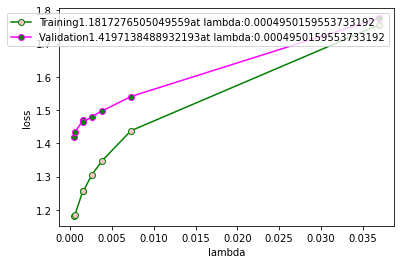

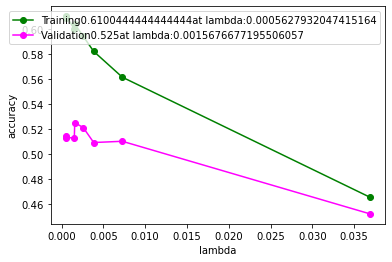

In [57]:
plot_metrics_grid(metrics_grid,lambdas)

In [58]:
lambdas_fine=[0,0.001,0.002,0.003,0.004,0.005,0.006]

In [59]:
metrics_grid=gridsearchCV(lambdas_fine, 50, X_new, Y_new, y_new, GDparams, X_val_new,
                Y_val_new, y_val_new)

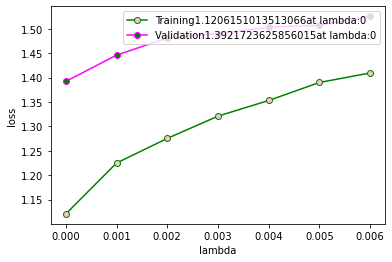

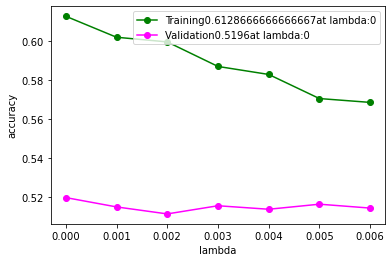

In [60]:
plot_metrics_grid(metrics_grid,lambdas_fine)

In [89]:
Xtest,ytest,Ytest = loading_batch('test_batch')


In [88]:
X_Final.shape

(3072, 45000)

In [90]:
X_test_new.shape

(3072, 10000)

In [91]:
W1.shape

(50, 3072)

In [92]:
W2.shape

(10, 50)

In [105]:

eta_min=1e-5
eta_max=1e-1
step_size=900
n_batch=100
cycles=3 
GDparams=(eta_min,eta_max,step_size,n_batch,cycles)
W1_final, b1_final, W2_final, b2_final, final_metrics= MiniBatchGD(X_new, Y_new, y_new, GDparams, W1, W2, b1, b2,X_val_new,Y_val_new,y_val_new, lambdax=0.001)

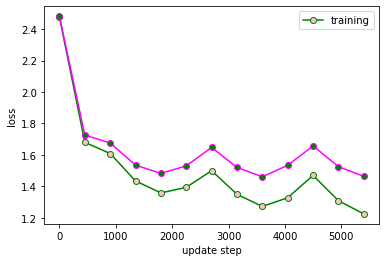

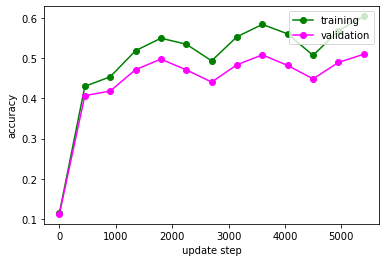

In [106]:
plot_graph(final_metrics)

In [107]:
print(final_metrics)

{'updates': [-1, 450, 900, 1350, 1800, 2250, 2700, 3150, 3600, 4050, 4500, 4950, 5400], 'Loss_scores': [2.4762579553680393, 1.6800278307551824, 1.6091742311905772, 1.43454629692286, 1.3588722617270845, 1.3941214061784264, 1.5000889587859634, 1.3496781527023474, 1.272689840002851, 1.3279844431921972, 1.4701118315275659, 1.309349960597355, 1.2252221336672908], 'acc_scores': [0.11486666666666667, 0.43015555555555557, 0.45393333333333336, 0.5189333333333334, 0.5501111111111111, 0.5351777777777778, 0.4938, 0.5538, 0.5844444444444444, 0.5608666666666666, 0.5072444444444445, 0.5688222222222222, 0.6048222222222223], 'Loss_val_scores': [2.4815173279615386, 1.7258143516648465, 1.6761790324429409, 1.535299060989933, 1.4826947849048961, 1.5305474643217891, 1.6476259459587845, 1.5207010562921615, 1.461335657372353, 1.534093106380892, 1.6572354215990281, 1.5257297843911735, 1.4638936233847455], 'acc_val_scores': [0.1124, 0.407, 0.4184, 0.4718, 0.498, 0.4712, 0.4408, 0.484, 0.5086, 0.4822, 0.4488, 0.